In [3]:
import matplotlib.pyplot as plt
import random
from rpmml_project.pointmaze.point_maze import MinariTrajectoryDataset

In [47]:
dataset = MinariTrajectoryDataset(
    dataset_name="D4RL/pointmaze/umaze-v2",
    horizon=32
)

In [48]:
env = dataset.dataset.recover_environment()

def unwrap_env(env):
    while hasattr(env, "env"):
        env = env.env
    return env

env = unwrap_env(env)

mj_model = env.model
mj_data = env.data

In [49]:
from matplotlib.patches import Rectangle
import mujoco

In [50]:
print(len(dataset))

639438


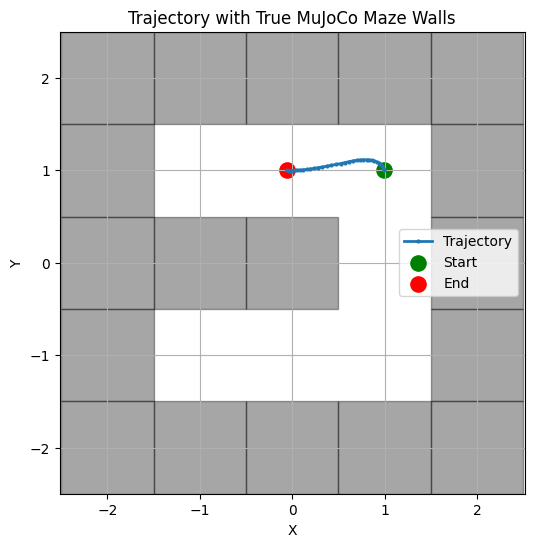

In [52]:
# Sample a trajectory window
idx = random.randint(0, len(dataset) - 1)
traj_norm = dataset[idx]
traj = dataset.denormalize(traj_norm).numpy()
xy = traj[:, :2]           # XY coordinates (i.e., flat outputs)

# Plot the trajectory
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(xy[:, 0], xy[:, 1], marker='o', linewidth=2, markersize=2, label='Trajectory')
ax.scatter(xy[0, 0], xy[0, 1], c='green', s=120, label='Start')
ax.scatter(xy[-1, 0], xy[-1, 1], c='red', s=120, label='End')

# Render MuJoCo walls
for geom_id in range(mj_model.ngeom):

    # Get geom name
    name = mujoco.mj_id2name(mj_model, mujoco.mjtObj.mjOBJ_GEOM, geom_id)

    if name is None or not "block" in name:
        continue

    pos = mj_model.geom_pos[geom_id]     # center (x, y, z)
    size = mj_model.geom_size[geom_id]   # half-extents (hx, hy, hz)

    cx, cy = pos[:2]
    hx, hy = size[:2]

    rect = Rectangle(
        (cx - hx, cy - hy),
        2 * hx,
        2 * hy,
        color="black",
        alpha=0.35,
        zorder=0
    )
    ax.add_patch(rect)

# Final figure styling
ax.set_title("Trajectory with True MuJoCo Maze Walls")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.axis("equal")
ax.grid(True)
ax.legend()
plt.xlim(-2.5, +2.5)
plt.ylim(-2.5, +2.5)

plt.show()